# JPMorgan Chase & Co. Quantitative Research

### Task 1: Investigate and analyze price data
Requirements:
- Download the monthly natural gas price data.
- Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
- Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
- Your code should take a date as input and return a price estimate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import itertools
import warnings
from math import ceil
from datetime import date

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9


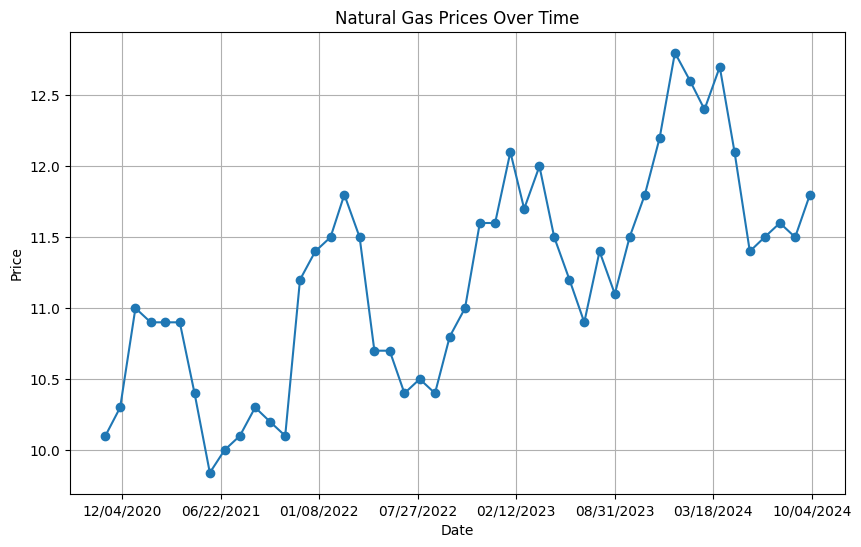

In [2]:
# Load and explore the data
data = pd.read_csv('Nat_Gas.csv')
print(data.head())
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(data['Dates'], data['Prices'], marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices Over Time')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # Set the number of ticks on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y')) # Set the date format
plt.grid(True)
plt.show()


Based on the plotted data, it appears that there is both a seasonal pattern and a trend over time. SARIMA models are a good choice for time series data with a trend and seasonality. They extend the ARIMA model to support the direct modeling of seasonal effects.

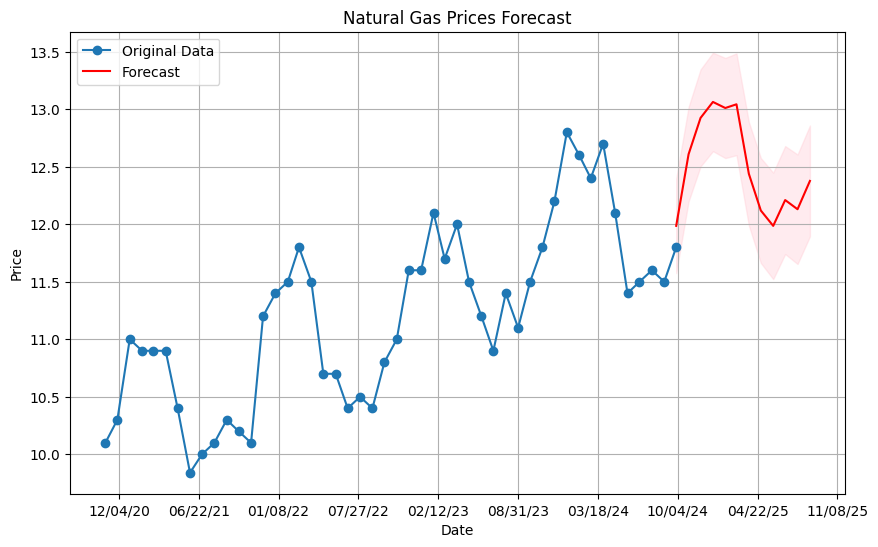

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
data.set_index('Dates', inplace=True)
data.index = pd.DatetimeIndex(data.index.values, freq='ME')
# Fit a SARIMA model
# Define the SARIMA model parameters
# (p, d, q) x (P, D, Q, s) - where s is the period of seasonality
model = SARIMAX(data['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)

# Forecast for the next 12 months
forecast = sarima_fit.get_forecast(steps=12)
forecast_index = pd.date_range(data.index[-1], periods=12, freq='ME')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Prices'], label='Original Data', marker='o')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices Forecast')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # Set the number of ticks on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y')) # Set the date format
plt.legend()
plt.grid(True)
plt.show()

Best SARIMA model: order=(1, 0, 2), seasonal_order=(2, 1, 2, 12) with AIC=-9.918696262070782


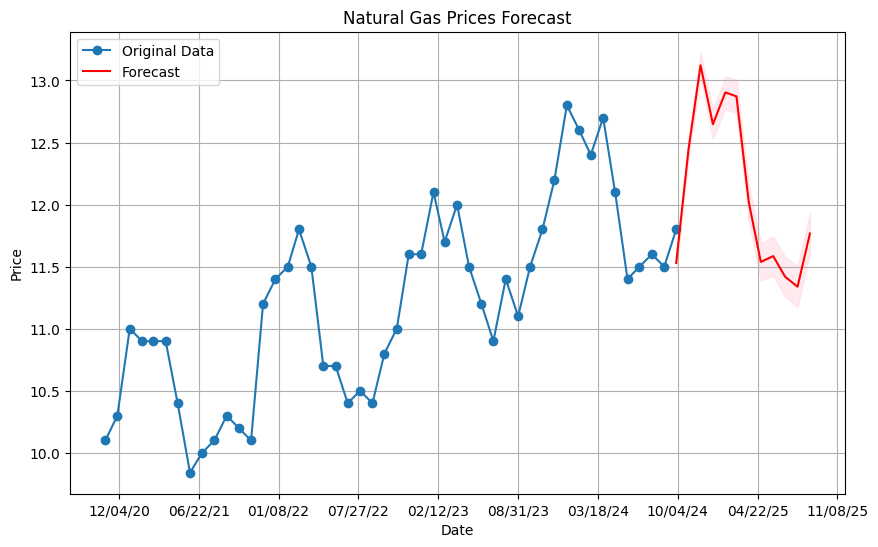

In [4]:
# Tune the SARIMA model
# Define parameter ranges
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = 12  # Seasonal period (e.g., monthly data with yearly seasonality)

# Generate all different combinations of p, d, q triplets
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
# Generate all different combinations of P, D, Q, s triplets
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_aic = np.inf # Akaike Information Criterion
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(data['Prices'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

print(f'Best SARIMA model: order={best_pdq}, seasonal_order={best_seasonal_pdq} with AIC={best_aic}')

# Fit the best model
best_model = SARIMAX(data['Prices'],
                     order=best_pdq,
                     seasonal_order=best_seasonal_pdq,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit(disp=False)

# Forecast for the next 12 months
forecast = best_model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(data.index[-1], periods=12, freq='ME')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Prices'], label='Original Data', marker='o')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices Forecast')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # Set the number of ticks on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y')) # Set the date format
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Predice the price for a single date
def predict_price_for_date(fitted_model, start_date, target_date):
    # Convert input dates to datetime
    start_date = pd.to_datetime(start_date)
    target_date = pd.to_datetime(target_date)
    
    # Calculate the number of steps to forecast
    steps = (target_date.year - start_date.year) * 12 + (target_date.month - start_date.month)
    
    if steps <= 0:
        raise ValueError("The target date must be after the start date.")
    
    # Forecast for the required number of steps
    forecast = fitted_model.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    
    # Get the predicted price for the target date
    predicted_price = forecast_values.iloc[-1]
    
    return predicted_price

In [6]:
# Example Usage
cur_date = data.index[-1]
target_date = '2024-11-30'
predicted_price = predict_price_for_date(best_model_fit, cur_date, target_date)

# Display the predicted price
print(f"Predicted price for {target_date}: {predicted_price}")

Predicted price for 2024-11-30: 12.448746384803913


The plot shows a clear seasonal pattern where the prices tend to rise and fall at certain times of the year. From the original data, there is also a general upward trend. Natural gas prices are influenced by a complex range of factors, such as seasonal trends, supply and demand dynamics, market conditions, and external factors. The observed seasonal patterns and forecasted trends in the data reflect these underlying influences.

### Task 2: Price a commodity storage contract
Requirements:
Write a function that is able to use the data you created previously to price the contract. The client may want to choose multiple dates to inject and withdraw a set amount of gas. Consider all the cash flows involved in the product.
The input parameters that should be taken into account for pricing are:
- Injection dates. 
- Withdrawal dates.
- The prices at which the commodity can be purchased/sold on those dates.
- The rate at which the gas can be injected/withdrawn.
- The maximum volume that can be stored.
- Storage costs.

Write a function that takes these inputs and gives back the value of the contract. You can assume there is no transport delay and that interest rates are zero. Market holidays, weekends, and bank holidays need not be accounted for. Test your code by selecting a few sample inputs.

In [7]:
def get_price_for_date(prices_df, date):
    """
    Get the price of natural gas for a given date from the prices DataFrame.
    
    Parameters:
    prices_df (pd.DataFrame): DataFrame containing dates and prices.
    date (str): The date for which to get the price.
    
    Returns:
    float: The price of natural gas on the given date.
    """
    date = pd.to_datetime(date)
    
    try:
        price = prices_df.loc[date, 'Prices']
    except KeyError:
        raise ValueError(f"No price data available for the date {date.strftime('%Y-%m-%d')}")
    
    return price

In [8]:
def price_contract(injection_dates, withdrawal_dates, injection_prices, withdrawal_prices, 
                   rate, max_vol, injection_withdrawal_cost, storage_cost):
    """
    Calculates the value of a contract based on injection and withdrawal dates, prices, and costs.

    Args:
        injection_dates (List[datetime.date]): List of dates on which gas is injected.
        withdrawal_dates (List[datetime.date]): List of dates on which gas is withdrawn.
        injection_prices (List[float]): List of prices at which gas is injected.
        withdrawal_prices (List[float]): List of prices at which gas is withdrawn.
        rate (float): Rate of gas injection/withdrawal per day.
        max_vol (float): Maximum volume of gas that can be stored.
        injection_withdrawal_cost (float): Cost of injection/withdrawal per unit of gas.
        storage_cost (float): Cost of storing gas per month.

    Returns:
        float: Value of the contract.
    """
    volume = 0
    buy_cost = 0
    revenue = 0
    
    # Ensure dates are in sequence
    all_dates = sorted(set(injection_dates + withdrawal_dates))
    
    for i in range(len(all_dates)):
        cur_date = all_dates[i]

        if cur_date in injection_dates:
            if volume <= max_vol - rate:
                volume += rate
                # Cost to purchase gas
                buy_cost += rate * injection_prices[injection_dates.index(cur_date)]
                # Injection cost
                injection_cost = rate * injection_withdrawal_cost
                buy_cost += injection_cost
                print('Injected gas on %s at a price of %s'%(cur_date, injection_prices[injection_dates.index(cur_date)]))
            else:
                print('Injection is not possible on date %s as there is insufficient space in the storage facility'%cur_date)
        elif cur_date in withdrawal_dates:
            if volume >= rate:
                volume -= rate
                # Revenue from selling
                revenue += rate * withdrawal_prices[withdrawal_dates.index(cur_date)]
                # Withdrawal cost
                withdrawal_cost = rate * injection_withdrawal_cost
                revenue -= withdrawal_cost
                print('Extracted gas on %s at a price of %s'%(cur_date, withdrawal_prices[withdrawal_dates.index(cur_date)]))
            else:
                print('Extraction is not possible on date %s as there is insufficient volume of gas stored'%cur_date)
                
    storage_cost = ceil((max(withdrawal_dates) - min(injection_dates)).days // 30) * storage_cost
    contract_value = revenue - storage_cost - buy_cost
    
    return contract_value

In [9]:
# Example usage of price_contract()
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)] # injection dates
in_prices = [20, 21, 20.5, 22] # prices on the injection days
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)] # extraction dates
out_prices = [23, 19, 21, 25] # prices on the extraction days
rate = 100000  # rate of gas in cubic feet per day
storage_cost_rate = 10000  # total volume in cubic feet
injection_withdrawal_cost_rate = 0.0005  # $/cf
max_storage_volume = 500000 # maximum storage capacity of the storage facility
result = price_contract(in_dates, out_dates, in_prices, out_prices, rate, max_storage_volume, injection_withdrawal_cost_rate, storage_cost_rate)
print()
print(f"The value of the contract is: ${result}")

Injected gas on 2022-01-01 at a price of 20
Extracted gas on 2022-01-27 at a price of 23
Injected gas on 2022-02-01 at a price of 21
Extracted gas on 2022-02-15 at a price of 19
Injected gas on 2022-02-21 at a price of 20.5
Extracted gas on 2022-03-20 at a price of 21
Injected gas on 2022-04-01 at a price of 22
Extracted gas on 2022-06-01 at a price of 25

The value of the contract is: $399600.0


### Task 3: Credit risk analysis
Requirement:
Build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan. Produce a function that can take in the properties of a loan and output the expected loss.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

In [11]:
# Load the data
data = pd.read_csv('Loan_Data.csv')

# Split the data into features (X) and target (y)
X = data.drop(columns=['customer_id', 'default'])
y = data['default']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, xgb_y_pred))
print("AUC-ROC:", roc_auc_score(y_test, xgb_y_pred_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.98      0.98       348

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

AUC-ROC: 0.9998521471709665


In [12]:
def predict_probability_of_default(borrower_details_df):
    borrower_details_scaled = scaler.transform(borrower_details_df)
    prob_default = xgb_model.predict_proba(borrower_details_scaled)[:, 1]
    return prob_default[0]

def calculate_expected_loss(borrower_details_df, recovery_rate=0.10):
    loan_amt_outstanding = borrower_details_df['loan_amt_outstanding'].values[0]
    prob_default = predict_probability_of_default(borrower_details_df)
    expected_loss = loan_amt_outstanding * prob_default * (1 - recovery_rate)
    return expected_loss

In [13]:
# Example borrower details: [credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score]
borrower_details = pd.DataFrame([[3, 5000, 15000, 75000, 5, 720]], columns=X.columns)

# Predict the probability of default using XGBoost
prob_default_xgb = predict_probability_of_default(borrower_details)
print("Probability of Default (XGBoost):", prob_default_xgb)

# Calculate the expected loss using XGBoost
expected_loss_xgb = calculate_expected_loss(borrower_details)
print("Expected Loss (XGBoost):", expected_loss_xgb)

Probability of Default (XGBoost): 0.0003965873
Expected Loss (XGBoost): 1.7846428672783077


### Task 4: Bucket FICO scores
Given a set number of buckets corresponding to the number of input labels for the model, find out the boundaries that best summarize the data.

In [14]:
data = pd.read_csv('Loan_Data.csv')

# Define a function to create buckets based on K-means clustering to minimize MSE
def create_buckets(data, n_buckets):
    fico_scores = data['fico_score'].values.reshape(-1, 1)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_buckets, random_state=0)
    kmeans.fit(fico_scores)
    
    # Get the cluster centers and sort them
    centers = sorted(kmeans.cluster_centers_.flatten())
    
    # Calculate the boundaries
    boundaries = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
    boundaries = [min(fico_scores)[0]] + boundaries + [max(fico_scores)[0]]
    
    return boundaries

# Define a function to map a FICO score to a bucket
def map_to_bucket(fico_score, boundaries):
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= fico_score < boundaries[i + 1]:
            return i + 1
    return len(boundaries) - 1  # For the upper bound

In [15]:
# Example use
n_buckets = 10
boundaries = create_buckets(data, n_buckets)

print("Bucket Boundaries:")
for i in range(len(boundaries) - 1):
    print(f"Bucket {i+1}: {boundaries[i]} to {boundaries[i+1]}")

example_fico_score = 650
bucket = map_to_bucket(example_fico_score, boundaries)
print(f"FICO score {example_fico_score} belongs to bucket {bucket}")

Bucket Boundaries:
Bucket 1: 408 to 519.3385695762951
Bucket 2: 519.3385695762951 to 561.9440483329336
Bucket 3: 561.9440483329336 to 594.6455343385428
Bucket 4: 594.6455343385428 to 623.1180221324186
Bucket 5: 623.1180221324186 to 649.125695059583
Bucket 6: 649.125695059583 to 674.3483990039365
Bucket 7: 674.3483990039365 to 700.1425847863577
Bucket 8: 700.1425847863577 to 728.015124239351
Bucket 9: 728.015124239351 to 764.3445360040569
Bucket 10: 764.3445360040569 to 850
FICO score 650 belongs to bucket 6
